In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_rows = None
import matplotlib.pyplot as plt

In [9]:
# loading data

# all the relevant data integrated in one place
all_segs = pd.read_csv("Results\integrated_data.csv", index_col=0)

# All interventions

In [27]:
def trigger_to_fixation_time(all_segs):

    # select relevant columns
    TTFT = all_segs[['sc_id', 'msnv_id', 'intervention', 'trigger_to_fixation_time']]

    # group by ['sc_id', 'msnv_id']
    # MPPD: means per participant per document
    # (remove sort = false for ordered based on type)
    TTFT_MPPD = TTFT.groupby(['sc_id', 'msnv_id'], sort=False).apply(
        lambda x: pd.Series({
            'doc mean trig2fix_time': (x['trigger_to_fixation_time'].mean()),
            'doc std trig2fix_time' : (x['trigger_to_fixation_time'].std()),
            'doc AOI count'         : (x['trigger_to_fixation_time'].count())
            }))

    # group by ['sc_id']
    # MPP: means per participant
    TTFT_MPP = TTFT_MPPD.groupby(['sc_id']).apply(
        lambda x: pd.Series({
            'user mean trig2fix_time': (x['doc mean trig2fix_time'].mean()),
            'user std trig2fix_time' : (x['doc mean trig2fix_time'].std())
            }))

    # plot
    ttftp = TTFT_MPP[['user mean trig2fix_time', 'user std trig2fix_time']].sort_values(by='user mean trig2fix_time')
    ttftp.plot.bar(figsize=(15,5), title='Trigger to fixation times (outliers excluded)'); 

    # grand mean and std
    print("\n trigger_to_fixation_times")
    print("\t trig2fix_time grand mean: ", TTFT_MPP['user mean trig2fix_time'].mean())
    print("\t trig2fix_time grand sdt:"  , TTFT_MPP['user mean trig2fix_time'].std())

original data: (1422, 10)
filtered data: (892, 10)

 trigger_to_fixation_times
	 trig2fix_time grand mean:  11780.314816327993
	 trig2fix_time grand sdt: 4341.134245608094


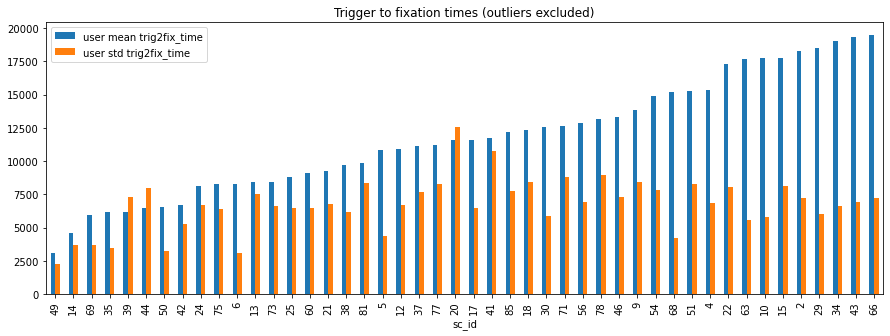

In [28]:
# filter outliers (trigger_to_fixation_time > Mean + 2SD)
mean, SD = 16420, 7766
all_segs_NOL = all_segs[all_segs['trigger_to_fixation_time'] < (mean + 2*SD)]

print(f'original data: {all_segs.shape}')
print(f'filtered data: {all_segs_NOL.shape}')

trigger_to_fixation_time(all_segs_NOL)

# interventions processed when highlighted

In [23]:
# sort based on 'trigger_start_stamp'
all_segs_active = all_segs.sort_values(by=['sc_id','msnv_id','trigger_start_stamp']).reset_index(drop=True)
# add 'fade_stamp' indicating fading time
all_segs_active.insert(loc=5, column='fade_stamp', value=0)

# sss: segment start stamp
# ttff: time to first fixation
# compute the timestamp of the first fixation
firstfixation_stamp = []

for sss, ttff in zip(all_segs_active['seg_start_stamp'], all_segs_active['timetofirstfixation']):
    
    if ttff != -1:
        # if ever fixate on the intervention
        firstfixation_stamp.append(sss + ttff)
    else:
        # if never fixate on the intervention
        firstfixation_stamp.append(-1)
        
all_segs_active.insert(loc=7, column='firstfixation_stamp', value=firstfixation_stamp)

# compute the fading timestamp
fade_stamp = []
for index in all_segs_active.index:
    if index +1 <= all_segs_active.index.max():
        if all_segs_active.loc[index, 'msnv_id'] == all_segs_active.loc[index +1, 'msnv_id']:
            # if the next intervention is in the same document (segment) -> set to the trigger of the next
            fade_stamp.append(all_segs_active.loc[index +1, 'trigger_start_stamp'])
        else:
            # if it is the last intervention of the segment -> set to the 'seg_end_stamp'
            fade_stamp.append(all_segs_active.loc[index, 'seg_end_stamp'])
    else:
            fade_stamp.append(all_segs_active.loc[index, 'seg_end_stamp'])
            
all_segs_active['fade_stamp'] = fade_stamp

# column indicating whetherthe intervention was processed while active
processed_immediately = []

for trigger_start_stamp, fade_stamp, firstfixation_stamp in zip(
    all_segs_active['trigger_start_stamp'], all_segs_active['fade_stamp'], all_segs_active['firstfixation_stamp']):
    
    if trigger_start_stamp < firstfixation_stamp and firstfixation_stamp < fade_stamp:
        # if trigger_start_stamp < firstfixation < fade_stamp
        processed_immediately.append(1)
    else:
        processed_immediately.append(0)

all_segs_active['imm_processed'] = processed_immediately
# all_segs_active.to_csv("Results\\integrated_data_active.csv", index=True)
display(all_segs_active.head(10))

,sc_id,msnv_id,intervention,seg_start_stamp,trigger_start_stamp,fade_stamp,seg_end_stamp,firstfixation_stamp,trigger_delay,numfixations,timetofirstfixation,trigger_to_fixation_time,imm_processed
0,2,3,3_ref_106_rule,682955,689819.0,700002.0,743171,723534.0,6864.0,7.0,40579.0,33715.0,0
1,2,3,3_ref_101_rule,682955,700002.0,704499.0,743171,732361.0,17047.0,2.0,49406.0,32359.0,0
2,2,3,3_ref_100_rule,682955,704499.0,710869.0,743171,-1.0,21544.0,0.0,-1.0,NaN,0
3,2,3,3_ref_105_rule,682955,710869.0,716506.0,743171,729072.0,27914.0,3.0,46117.0,18203.0,0
4,2,3,3_ref_102_rule,682955,716506.0,743171.0,743171,-1.0,33551.0,0.0,-1.0,NaN,0
5,2,5,5_ref_100_rule,549675,568299.0,578191.0,643899,608617.0,18624.0,10.0,58942.0,40318.0,0
6,2,5,5_ref_101_rule,549675,578191.0,582712.0,643899,608475.0,28516.0,4.0,58800.0,30284.0,0
7,2,5,5_ref_103_rule,549675,582712.0,589723.0,643899,625430.0,33037.0,18.0,75755.0,42718.0,0
8,2,5,5_ref_104_rule,549675,589723.0,643899.0,643899,631717.0,40048.0,1.0,82042.0,41994.0,1
9,2,9,9_ref_101_rule,904609,914665.0,922750.0,959986,933180.0,10056.0,11.0,28571.0,18515.0,0


processed while active data: (603, 13)
original data: (1422, 13)
filtered data: (892, 13)

 trigger_to_fixation_times
	 trig2fix_time grand mean:  9721.229378733184
	 trig2fix_time grand sdt: 3842.5142260482944


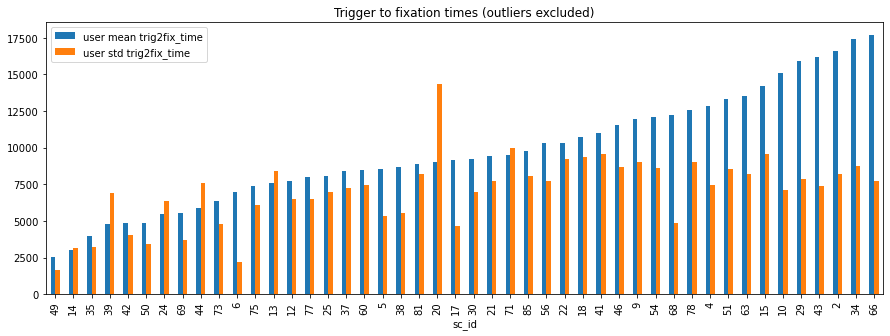

In [29]:
# filter outliers (trigger_to_fixation_time > Mean + 2SD)
mean, SD = 16420, 7766
all_segs_active_NOL = all_segs_active[all_segs_active['trigger_to_fixation_time'] < (mean + 2*SD)]

# keep only interventions that were processed when highlighted
all_segs_active_NOL_H = all_segs_active_NOL[all_segs_active_NOL['imm_processed'] == 1]
print(f'processed while active data: {all_segs_active_NOL_H.shape}')

print(f'original data: {all_segs_active.shape}')
print(f'filtered data: {all_segs_active_NOL.shape}')

trigger_to_fixation_time(all_segs_active_NOL_H)

# interventions processed when faded

processed while faded data: (289, 13)
original data: (1422, 13)
filtered data: (892, 13)

 trigger_to_fixation_times
	 trig2fix_time grand mean:  17996.84154445595
	 trig2fix_time grand sdt: 4548.716051903558


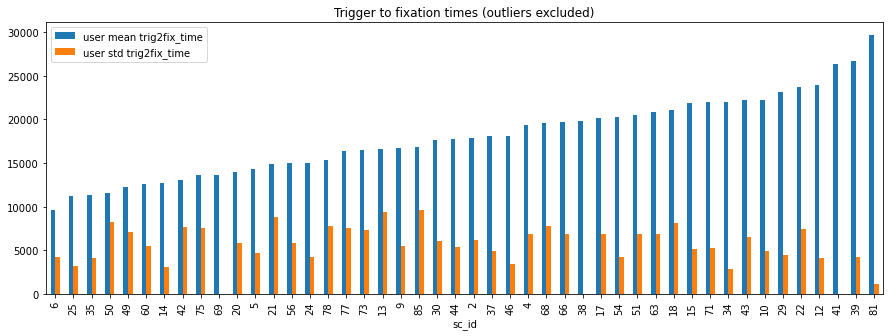

In [38]:
# filter outliers (trigger_to_fixation_time > Mean + 2SD)
mean, SD = 16420, 7766
all_segs_active_NOL = all_segs_active[all_segs_active['trigger_to_fixation_time'] < (mean + 2*SD)]

# keep only interventions that were processed when faded
all_segs_active_NOL_F = all_segs_active_NOL[all_segs_active_NOL['imm_processed'] == 0]
print(f'processed while faded data: {all_segs_active_NOL_F.shape}')

print(f'original data: {all_segs_active.shape}')
print(f'filtered data: {all_segs_active_NOL.shape}')

trigger_to_fixation_time(all_segs_active_NOL_F)